In [1]:
"""
follow up analysis for ABA and ST all by all
data figure 1

Shaina Lu
Zador & Gillis Labs
April 2020
"""

'\nfollow up analysis for ABA and ST all by all\ndata figure 1\n\nShaina Lu\nZador & Gillis Labs\nApril 2020\n'

In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split #stratify train/test split
import random

In [3]:
def set_style():
    #function for matplotlib formatting
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

# Read in Data

In [4]:
#infiles
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v2.h5"
ALLEN_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5" #v6 averaged duplicates
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"

In [5]:
#ontology
ontology = pd.read_csv(ONTOLOGY_PATH)
ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
ontology = ontology.fillna(-1)  #make root's parent -1

In [6]:
#ST
STspotsmeta = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspotsmeta', mode='r')
STspots = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspots', mode='r')
STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')

In [7]:
#ABA
ABAvoxmeta = pd.read_hdf(ALLEN_FILT_PATH, key='metabrain', mode='r')
ABAvox = pd.read_hdf(ALLEN_FILT_PATH, key='avgvoxbrain', mode='r')
ABApropont = pd.read_hdf(ALLEN_FILT_PATH, key='propontology', mode='r')
geneIDName = pd.read_hdf(ALLEN_FILT_PATH, key='geneIDName', mode='r')

__pre-filter ST and ABA datasets as is done for all by all in each case__

copied and pasted pre-processing functions

In [8]:
def zscore(voxbrain):
    """zscore voxbrain or subsets of voxbrain (rows: voxels, cols: genes)"""
    #z-score 
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(voxbrain)
    z_voxbrain = scaler.transform(voxbrain, copy=True)
    
    #store z-scored voxbrain as pandas dataframe
    z_voxbrain = pd.DataFrame(z_voxbrain)
    z_voxbrain.columns = voxbrain.columns
    z_voxbrain.index = voxbrain.index
    
    return z_voxbrain

def splitdata(data, testratio):
    """generic fcn to split data in train/test folds"""
    #set seed so train and test will always split the same in diff run so ML algorithm doesn't see whole dataset (BAD)
    np.random.seed(42)
    shuffindices = np.random.permutation(len(data))
    testsize = int(len(data) * testratio)
    testindices = shuffindices[:testsize]
    trainindices = shuffindices[testsize:]
    return data.iloc[trainindices], data.iloc[testindices]

def filterproponto(sampleonto):
    """pre-processing for propogated ontology for ST data"""
    #remove brain areas that don't have any samples
    sampleonto_sums = sampleonto.apply(lambda col: col.sum(), axis=0)
    sampleonto = sampleonto.loc[:,sampleonto_sums > 5] #greater than 5 becuase less is not enough for train/test split to have non-zero areas
    
    return sampleonto

def getleaves(propontvox, ontology):
    #leaves are brain areas in the ontology that never show up in the parent column
    allareas = list(propontvox)
    parents = list(ontology.parent)
    for i in range(len(parents)): #convert parents from float to int, ids are ints
        parents[i] = int(parents[i])
    
    #remove parents from all areas
    leaves = []
    for area in allareas:
        if int(area) not in parents:
            leaves.append(area)
    
    return leaves

In [9]:
#ST pre-processing
STpropont = filterproponto(STpropont)
STspots = STspots.astype('float64') #convert int to float for z-scoring
#get leaf areas
leaves = getleaves(STpropont, ontology)
leafSTpropont = STpropont.loc[STspotsmeta.id.isin(leaves),leaves] #subset prop onto for leaf areas
leafSTspots = STspots.loc[STspotsmeta.id.isin(leaves),:] #subset data for samples from leaves

In [10]:
#ABA pre-processing
ABApropont = filterproponto(ABApropont)
#get leaf ares only
leaves = getleaves(ABApropont,ontology)
leafABApropont = ABApropont.loc[ABAvoxmeta.ids.isin(leaves),leaves] #subset propontvox for leaf areas
leafABAvox = ABAvox.loc[ABAvoxmeta.ids.isin(leaves),:] #subset voxbrain for voxels from leaves

# Examples for learnability of ARA brain areas in both ABA ISH and ST

Explain what an AUROC means via example: in an average performing brain area in each dataset, how many voxels are misclassified?

__read in AUROC files from ABA ISH and ST w/ lasso alpha = 0.1__

In [13]:
#load in test AUROC's from ABA
#TRAIN1_ALLBYALL_PATH = "allbyallABA0p1_train0420.csv"
TEST1_ALLBYALL_PATH = "/home/slu/spatial/data/allbyallABA0p1_test0420.csv"
#TRAIN2_ALLBYALL_PATH = "allbyallABA0p1_f2_train0420.csv"
TEST2_ALLBYALL_PATH = "/home/slu/spatial/data/allbyallABA0p1_f2_test0420.csv"

In [14]:
#fold1
#train_allbyall_f1 = pd.read_csv(TRAIN1_ALLBYALL_PATH, sep=',')
#train_allbyall_f1 = train_allbyall_f1.set_index(train_allbyall_f1.columns)

ABA_test_f1 = pd.read_csv(TEST1_ALLBYALL_PATH, sep=',')
ABA_test_f1 = ABA_test_f1.set_index(ABA_test_f1.columns)

#fold2
#train_allbyall_f2 = pd.read_csv(TRAIN2_ALLBYALL_PATH, sep=',')
#train_allbyall_f2 = train_allbyall_f2.set_index(train_allbyall_f2.columns)

ABA_test_f2 = pd.read_csv(TEST2_ALLBYALL_PATH, sep=',')
ABA_test_f2 = ABA_test_f2.set_index(ABA_test_f2.columns)

In [15]:
#average the test performance across the two folds
ABA_test_allbyall_avg = (ABA_test_f1 + ABA_test_f2)/2

In [16]:
#ST
ST_TEST1_ALLBYALL_PATH = "/home/slu/spatial/data/allbyallST0p1_f1_test0508.csv"
ST_TEST2_ALLBYALL_PATH = "/home/slu/spatial/data/allbyallST0p1_f2_test0508.csv"

In [17]:
ST_test_f1 = pd.read_csv(ST_TEST1_ALLBYALL_PATH, sep=',')
ST_test_f1 = ST_test_f1.set_index(ST_test_f1.columns)

ST_test_f2 = pd.read_csv(ST_TEST2_ALLBYALL_PATH, sep=',')
ST_test_f2 = ST_test_f2.set_index(ST_test_f2.columns)

In [18]:
ST_test_allbyall_avg = (ST_test_f1 + ST_test_f2)/2

__summary statistics to define an average performing area__

In [19]:
ABA_test_avg_upper = ABA_test_allbyall_avg.values[np.triu_indices_from(ABA_test_allbyall_avg, k=1)]
ABA_test_avg_upper = ABA_test_avg_upper[ABA_test_avg_upper != 0] #remove 0's

In [20]:
sp.stats.describe(ABA_test_avg_upper)

DescribeResult(nobs=156519, minmax=(0.18333333333333338, 1.0000000000000018), mean=0.9958435754281836, variance=0.0011406135866141062, skewness=-11.586730164203207, kurtosis=151.2754293908355)

In [21]:
np.median(ABA_test_avg_upper)

1.0

In [22]:
#what's the median for either of the folds?
print(np.median(ABA_test_f1.values[np.triu_indices_from(ABA_test_f1, k=1)]))
print(np.median(ABA_test_f2.values[np.triu_indices_from(ABA_test_f2, k=1)]))

1.0
1.0


In [23]:
ST_test_avg_upper = ST_test_allbyall_avg.values[np.triu_indices_from(ST_test_allbyall_avg, k=1)]
#no 0's here

In [24]:
sp.stats.describe(ST_test_avg_upper)

DescribeResult(nobs=106030, minmax=(0.04999999999999999, 1.0000000000000009), mean=0.8829401965771095, variance=0.023905302593669842, skewness=-1.487979543773035, kurtosis=1.4227267641611476)

In [25]:
np.median(ST_test_avg_upper)

0.9591836734693878

In [26]:
#what's the median for either of the folds?
print(np.median(ST_test_f1.values[np.triu_indices_from(ST_test_f1, k=1)]))
print(np.median(ST_test_f2.values[np.triu_indices_from(ST_test_f2, k=1)]))

0.9691119691119692
0.9727272727272728


NOTE: the median did not change for either fold between the first version of this with the wrong filtering and the correct filtering. So did not re-run the rest of this sub-section.

In [59]:
#which brain areas are the median performing area for the average?
STmedareas = np.where(ST_test_allbyall_avg == 0.9591836734693878)
print(STmedareas)

(array([ 14,  14,  46,  94,  94, 105, 105, 115, 166, 232, 342, 359, 362]), array([227, 362, 111, 111, 409, 306, 406, 166, 430, 289, 439, 430, 378]))


In [109]:
#what about the median of the two folds?
fold1medareas = np.where(ST_test_f1 == 0.9691119691119692)
print(fold1medareas)
fold2medareas = np.where(ST_test_f2 == 0.9727272727272728)
print(fold2medareas)

(array([ 38,  78,  97, 105, 139, 149, 178, 287]), array([460, 279, 431, 279, 390, 154, 223, 350]))
(array([  2,  10,  23,  30,  50,  52,  91,  91,  96, 104, 104, 112, 116,
       143, 185, 189, 225, 253, 260, 260, 286, 318, 371, 384, 386, 411]), array([101,  88, 414, 174, 451, 454, 196, 198, 386, 205, 373, 236, 422,
       303, 260, 301, 451, 410, 361, 418, 360, 414, 418, 454, 457, 415]))


In [52]:
ST_test_allbyall_avg.iloc[14,362]

0.9591836734693878

In [75]:
ST_test_f1.iloc[14,362]

1.0

For ABA, the median performing brain areas pairs have an AUROC=1, which means that they classify all voxels perfectly. For ST, there are 13 brain area pairs that have the median AUROC=0.9591836734693878 when the two test folds are averaged. Let's see how many spots are incorrectly classified for these brain area pairs in the following section. \
\
In the end we looked at the medians performing brain areas from each of the two folds separately because the median pairs from the averaged test fold may have a non-representative AUROC in one of the folds (i.e. AUROC=1).

__How many incorrectly classified spots in ST median AUROC brain area pairs?__

Here, we look at precision in the top half of the list.

In [199]:
#AUROC
def analytical_auroc(featurevector, binarylabels):
    """analytical calculation of auroc
       inputs: feature (mean rank of expression level), binary label
       returns: auroc
    """
    #sort ctxnotctx binary labels by mean rank, aescending
    s = sorted(zip(featurevector, binarylabels))
    feature_sort, binarylabels_sort = map(list, zip(*s))
    #print(feature_sort)
    print(binarylabels_sort)
    
    #how many 0's in the top half of the list?
    numneg = 0
    for i in range(len(binarylabels_sort)-1,int(len(binarylabels_sort)/2),-1): #include 1 extra in top half for odd length lists
        if binarylabels_sort[i] == 1:
            numneg += 1
    #this is precision for the top half of the list
    numneg = numneg/int(len(binarylabels_sort)/2)

    #get the sum of the ranks in feature vector corresponding to 1's in binary vector
    sumranks = 0
    for i in range(len(binarylabels_sort)):
        if binarylabels_sort[i] == 1:
            sumranks = sumranks + feature_sort[i]
    
    poslabels = binarylabels.sum()
    neglabels = (len(binarylabels) - poslabels) #- (len(binarylabels) - binarylabels.count())  #trying to subtract out 
    
    auroc = ((sumranks/(neglabels*poslabels)) - ((poslabels+1)/(2*neglabels)))
    
    return auroc, numneg

In [188]:
#probe specific brain areas we're interested in
def probemedianareas(data,propont,medareas): 
    areas = list(propont)
    precision1 = []
    for i in range(len(medareas[0])):
        area1 = areas[medareas[0][i]]
        area2 = areas[medareas[1][i]]
        #print(area1)
        #print(area2)
        #get binary label vectors
        ylabels = propont.loc[propont[area1]+propont[area2] != 0, area1]
        #subset train and test sets for only samples in the two areas
        Xcurr = data.loc[propont[area1]+propont[area2] != 0, :]
        #split train test for X data and y labels
        #split data function is seeded so all will split the same wa
        Xtrain, Xtest, ytrain, ytest = train_test_split(Xcurr, ylabels, test_size=0.5,\
                                                        random_state=42, shuffle=True,\
                                                        stratify=ylabels)

        #z-score current X data
        zXtrain = zscore(Xtrain)
        zXtest = zscore(Xtest)

        #LASSO
        #currauroc_train, currauroc_test = applyLASSO(zXtrain, zXtest, ytrain, ytest)
        lasso_reg = Lasso(alpha=0.1, max_iter=10000)
        #lasso_reg = LinearRegression()
        lasso_reg.fit(zXtrain, ytrain)

        #train
        predictions_train = lasso_reg.predict(zXtrain)
        #auroc_train = analytical_auroc(sp.stats.mstats.rankdata(predictions_train), ytrain)
        #test
        predictions_test = lasso_reg.predict(zXtest)
        auroc_test, currtopnegcount = analytical_auroc(sp.stats.mstats.rankdata(predictions_test), ytest)
        fpr, tpr, thresholds = metrics.roc_curve(y_true = ytest, y_score = predictions_test, pos_label = 1, drop_intermediate=False)
        precision1.append(currtopnegcount)
    
    return precision1

In [191]:
STprecision1 = probemedianareas(leafSTspots, leafSTpropont, fold1medareas)
STprecision2 = probemedianareas(leafSTspots, leafSTpropont, fold2medareas)

In [202]:
print(np.mean(STprecision1))
print(np.mean(STprecision2))

0.7399265227526097
0.7471516927741624


So, what ended up happening basically is that I calculated precision for the top half of any given list of ranked samples for the median performing brain area pairs. Saved as variables precision1 and precision2.

Look at precision when I get all the 1's - i.e. all the instances of one class

In [212]:
#AUROC
def analytical_auroc(featurevector, binarylabels):
    """analytical calculation of auroc
       inputs: feature (mean rank of expression level), binary label
       returns: auroc
    """
    #sort ctxnotctx binary labels by mean rank, aescending
    s = sorted(zip(featurevector, binarylabels))
    feature_sort, binarylabels_sort = map(list, zip(*s))
    #print(feature_sort)
    #print(binarylabels_sort)
    
    #how many 0's until i reach my last 1?
    truepos = 0
    for i in range(len(binarylabels_sort)-1,0,-1): #backwards cause sorted aescending
        if binarylabels_sort[i] == 1:
            truepos += 1
            lastposindex = i
    
    falsepos = 0
    for i in range(len(binarylabels_sort)-1,lastposindex,-1):
        if binarylabels_sort[i] == 0:
            falsepos += 1
            
    #this is precision for the top half of the list
    precision = truepos/(truepos+falsepos)

    #get the sum of the ranks in feature vector corresponding to 1's in binary vector
    sumranks = 0
    for i in range(len(binarylabels_sort)):
        if binarylabels_sort[i] == 1:
            sumranks = sumranks + feature_sort[i]
    
    poslabels = binarylabels.sum()
    neglabels = (len(binarylabels) - poslabels) #- (len(binarylabels) - binarylabels.count())  #trying to subtract out 
    
    auroc = ((sumranks/(neglabels*poslabels)) - ((poslabels+1)/(2*neglabels)))
    
    return auroc, precision

In [213]:
STprecision1 = probemedianareas(leafSTspots, leafSTpropont, fold1medareas)
STprecision2 = probemedianareas(leafSTspots, leafSTpropont, fold2medareas)

In [214]:
print(np.mean(STprecision1))
print(np.mean(STprecision2))

0.8367102342422437
0.848750084932345


In [216]:
np.mean([*STprecision1, *STprecision2])

0.8459171788876152

For the median performing pair of brain areas in ABA ISH, there is a threshold in classification that can be drawn where I can correctly predict all instances of one class without any false positives (precision = 1). In contrast, in the ST, no such threshold can be found for the median performing brain areas (average precision = 0.846).

# Caudoputamen: relationship between size and performance?

In the ABA ISH, the CP is the lowest performing brain area (it stands out on the heat map) and it happens to be the largest leaf brain area by sample size (and volume by definition). So, we ask: 
1. Is there a correlation between size and performance in general?
2. Does performance rise as you downsample in a particular brain region?
3. Is the CP more transcriptionally diverse in general? (average correlation of voxel profiles)

__What is the lowest performing area in ST? (Is it also the Caudoputamen?)__

In [111]:
def copyoverdiag(allbyall):
    #copy uppertriangular to lower triangular
    allbyall2 = allbyall
    allbyall2 = allbyall.fillna(0, inplace=False)
    temp = allbyall2.T
    allbyall2 = allbyall2.values  #convert to numpy
    temp = temp.values
    allbyall2[np.tril_indices_from(allbyall)] = temp[np.tril_indices_from(allbyall)]
    
    return allbyall2

In [112]:
STavgfull = copyoverdiag(ST_test_allbyall_avg)

In [117]:
min(np.mean(STavgfull, axis=0))

0.5889431987780576

In [119]:
np.where(np.mean(STavgfull, axis=0) == 0.5889431987780576)

(array([450]),)

In [121]:
list(ST_test_allbyall_avg)[450]

'421'

In [125]:
ontology.loc[ontology.id == 421,:]

,id,acronym,name,parent,allencolor
1258,421,VISl1,"Lateral visual area, layer 1",409.0,#08858C


No, the lowest performing area in the ST is not the CP, but VISI1 or lateral visual area, layer 1. 

In [152]:
for i in range(len(list(ST_test_allbyall_avg))):
    if list(ST_test_allbyall_avg)[i] == '672': #CP
        index = i

In [154]:
np.mean(STavgfull, axis=0)[index]

0.6193299545540688

__Is there a correlation between size and performance in general?__

Note: all by all AUROC data already read in above

In [31]:
#get number of samples per brain area
ABAsize = leafABApropont.sum(axis=0)
STsize = leafSTpropont.sum(axis=0)

In [34]:
#number of samples in CP in each dataset
print(ABAsize['672'])
print(STsize['672'])

3012.0
2051.0


In [36]:
#average number of samples not including CP
print(ABAsize.drop('672').mean())
print(STsize.drop('672').mean())

85.62075134168157
57.02608695652174


In [45]:
def getminsize(aurocdata,size):
    maxsize = pd.DataFrame(index=list(aurocdata),columns=list(aurocdata))
    minsize = pd.DataFrame(index=list(aurocdata),columns=list(aurocdata))
    areas = list(aurocdata)
    for i in range(aurocdata.shape[0]):
        size1 = size[areas[i]]
        print(i)
        for j in range(i+1,aurocdata.shape[0]):
            size2 = size[areas[j]]
            minsize.iloc[i,j] = min(size1,size2)
            maxsize.iloc[i,j] = max(size1,size2)
    
    return minsize, maxsize

In [ ]:
ABAminsize, ABAmaxsize = getminsize(ABA_test_allbyall_avg, ABAsize)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [49]:
STminsize, STmaxsize = getminsize(ST_test_allbyall_avg, STsize)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [77]:
#get upper triangulars
ABA_test_avg_upper = ABA_test_allbyall_avg.values[np.triu_indices_from(ABA_test_allbyall_avg, k=1)]
ST_test_avg_upper = ST_test_allbyall_avg.values[np.triu_indices_from(ST_test_allbyall_avg, k=1)]
ABAminsize_upper = ABAminsize.values[np.triu_indices_from(ABAminsize, k=1)]
STminsize_upper = STminsize.values[np.triu_indices_from(STminsize, k=1)]
ABAmaxsize_upper = ABAmaxsize.values[np.triu_indices_from(ABAmaxsize, k=1)]
STmaxsize_upper = STmaxsize.values[np.triu_indices_from(STmaxsize, k=1)]

Performance as a function of minimum size

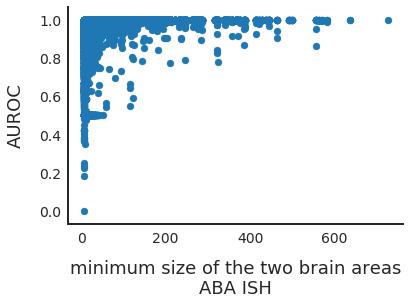

In [84]:
plt.scatter(ABAminsize_upper, ABA_test_avg_upper)
plt.xlabel("minimum size of the two brain areas\nABA ISH")
plt.ylabel("AUROC")
plt.savefig("051220_5.png", bbox_inches='tight')
plt.show()

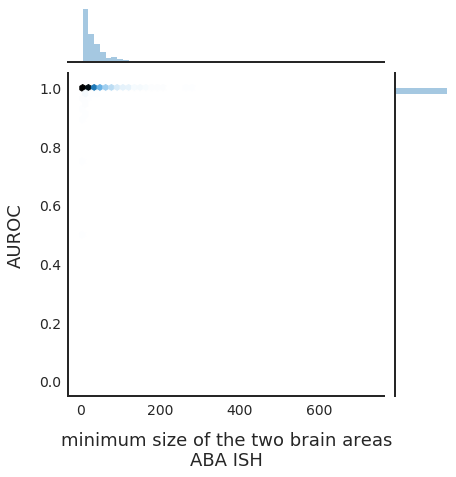

In [85]:
sns.jointplot(ABAminsize_upper, ABA_test_avg_upper, kind='hex') \
   .set_axis_labels("minimum size of the two brain areas\nABA ISH", "AUROC")
plt.savefig("051220_6.pdf", bbox_inches='tight')
plt.show()

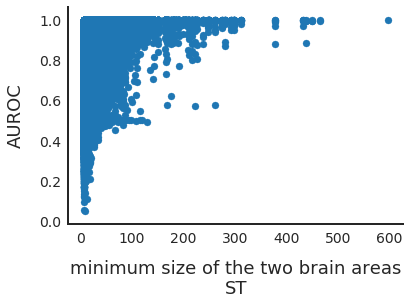

In [86]:
plt.scatter(STminsize_upper, ST_test_avg_upper)
plt.xlabel("minimum size of the two brain areas\nST")
plt.ylabel("AUROC")
plt.savefig("051220_7.png", bbox_inches='tight')
plt.show()

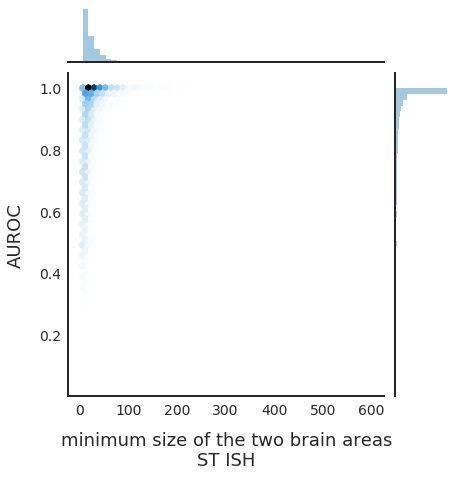

In [87]:
sns.jointplot(STminsize_upper, ST_test_avg_upper, kind='hex') \
   .set_axis_labels("minimum size of the two brain areas\nST ISH", "AUROC")
plt.savefig("051220_8.pdf", bbox_inches='tight')
plt.show()

Performance as a function of maximum size

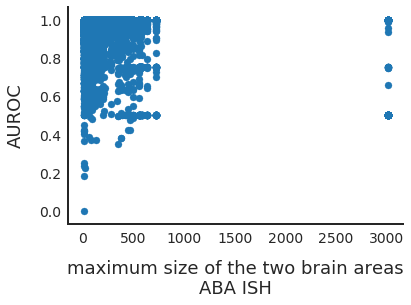

In [88]:
plt.scatter(ABAmaxsize_upper, ABA_test_avg_upper)
plt.xlabel("maximum size of the two brain areas\nABA ISH")
plt.ylabel("AUROC")
plt.savefig("051220_9.png", bbox_inches='tight')
plt.show()

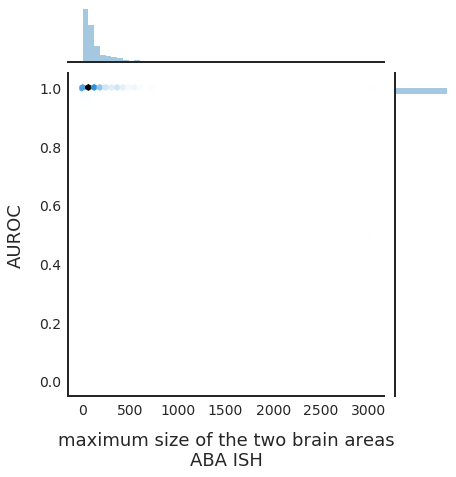

In [89]:
sns.jointplot(ABAmaxsize_upper, ABA_test_avg_upper, kind='hex') \
   .set_axis_labels("maximum size of the two brain areas\nABA ISH", "AUROC")
plt.savefig("051220_10.pdf", bbox_inches='tight')
plt.show()

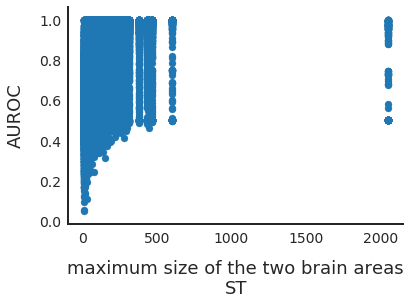

In [90]:
plt.scatter(STmaxsize_upper, ST_test_avg_upper)
plt.xlabel("maximum size of the two brain areas\nST")
plt.ylabel("AUROC")
plt.savefig("051220_11.png", bbox_inches='tight')
plt.show()

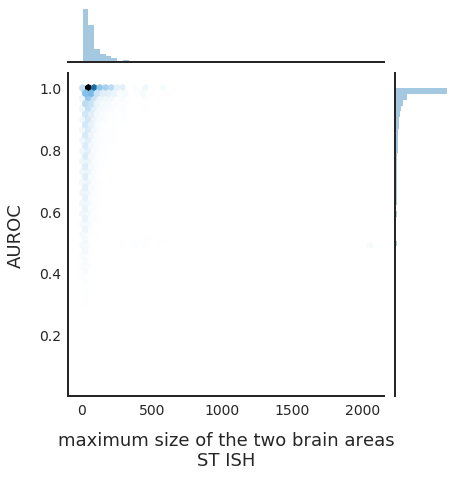

In [91]:
sns.jointplot(STmaxsize_upper, ST_test_avg_upper, kind='hex') \
   .set_axis_labels("maximum size of the two brain areas\nST ISH", "AUROC")
plt.savefig("051220_12.pdf", bbox_inches='tight')
plt.show()

Conclusion \
Looking at minimum or maximum size, there seems to be no correlation between size and performance in general when looking at minimum size of the two areas. The ABA ISH has all performance very near AUROC=1. The ST does seem to have a slight pattern where very small brain areas have a range of performance, but then there are very high performances for all other sizes.

__Does performance rise as you downsample in a particular brain region?__

Start by looking at caudoputamen

__Is the CP more transcriptionally diverse in general? (average correlation of voxel profiles)__

In [92]:
ontology.loc[ontology.acronym=="CP",:]

,id,acronym,name,parent,allencolor
1109,672,CP,Caudoputamen,485.0,#98D6F9


In [93]:
#get indices of the samples that map to CP
ABACPindex = ABApropont.loc[ABApropont['672']==1,'672'].index
STCPindex = STpropont.loc[STpropont['672']==1,'672'].index

In [94]:
#get the actual samples for all genes
CPvox = ABAvox.loc[ABACPindex, :]
CPspots = STspots.loc[STCPindex, :]

In [95]:
ABAcorr = np.corrcoef(CPvox, rowvar=1)

In [96]:
STcorr = np.corrcoef(CPspots, rowvar=1)

In [97]:
#mean upper triangular 
CPABAmeancorr = np.mean(ABAcorr[np.triu_indices_from(ABAcorr)])
CPABAabsmeancorr = np.mean(np.abs(ABAcorr[np.triu_indices_from(ABAcorr)]))
print(CPABAmeancorr)
print(CPABAabsmeancorr)

0.6652694737905721
0.6652694737905721


In [98]:
CPSTmeancorr = np.mean(STcorr[np.triu_indices_from(STcorr)])
CPSTabsmeancorr = np.mean(np.abs(STcorr[np.triu_indices_from(STcorr)]))
print(CPSTmeancorr)
print(CPSTabsmeancorr)

0.7273221133508818
0.7273221133508818


Looked at both the raw mean of correlation coefficients and the mean of the absolute value and they are identical in both datasets, so it seems that all correlations were positive. \
\
Need to compare to the average correlation of voxel profiles for other brain areas- see following section.

# Probing difference in performance b/t ST and ABA

__Distribution of average correlation expresison profiles within brain regions (i.e. is every brain region made up of voxels that look the same?)__ \
These took a bit of time to run, so they were quickly scripted and run from 9_STcorr.py and 11_ABAcorr.py. \
Outfiles: STareacorr_0504.csv and ABAareacorr_0504.csv

In [366]:
#infiles
#ABACORR_IN = "ABAareacorr_0504_2.csv"
#STCORR_IN = "STareacorr_0504_2.csv"

In [367]:
#ABAcorr = pd.read_csv(ABACORR_IN)
#STcorr = pd.read_csv(STCORR_IN)

In [128]:
def getareacorr(data, propont):
    #initialize zeros dataframe to store entries
    allbyall_corr = pd.DataFrame(index=list(propont), columns=["mean", "absmean"])
    
    areas = list(propont)
    #for each column, brain area
    for i in range(propont.shape[1]):
        area1 = areas[i]

        #subset train and test sets for only samples in curr area
        Xcurr = data.loc[propont[area1] != 0, :]
            
        #calculate within brain area correlations
        corrmat = np.corrcoef(Xcurr, rowvar=1) #corr b/t samples
        #corrmat = np.cov(Xcurr, rowvar=0) #cols are features, rows are samples
        absmean = np.mean(np.abs(corrmat[np.triu_indices_from(corrmat)]))
        mean = np.mean(corrmat[np.triu_indices_from(corrmat)])
            
        allbyall_corr.iloc[i,0] = mean
        allbyall_corr.iloc[i,1] = absmean
            
        #if i == 1:
        #break
     
    #return temp
    return allbyall_corr

In [129]:
STcorr = getareacorr(leafSTspots, leafSTpropont)

In [130]:
ABAcorr = getareacorr(leafABAvox, leafABApropont)

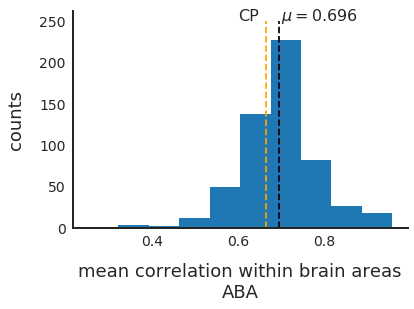

In [131]:
plt.hist(ABAcorr['mean'])
plt.xlabel("mean correlation within brain areas\nABA")
plt.ylabel("counts")
#caudoputamen
plt.vlines(x=CPABAmeancorr, ymin=0, ymax=250, linestyles='--', colors='orange')
plt.text(0.6, 250, "CP", fontsize=16)
#mean
plt.vlines(x=ABAcorr['mean'].mean(), ymin=0, ymax=250, linestyles='--')
plt.text(0.7, 250, "$\mu = %.3f$" %ABAcorr['mean'].mean(), fontsize=16)

plt.savefig("051220_13.pdf", bbox_inches='tight')
plt.show()

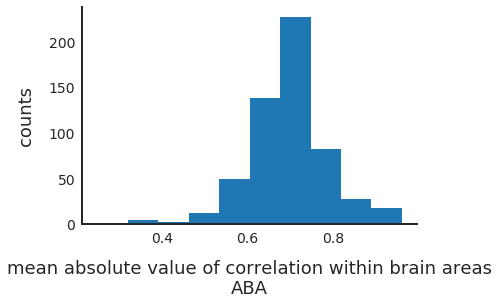

In [132]:
plt.hist(ABAcorr['absmean'])
plt.xlabel("mean absolute value of correlation within brain areas\nABA")
plt.ylabel("counts")
#plt.savefig("050420_7.pdf", bbox_inches='tight')
plt.show()

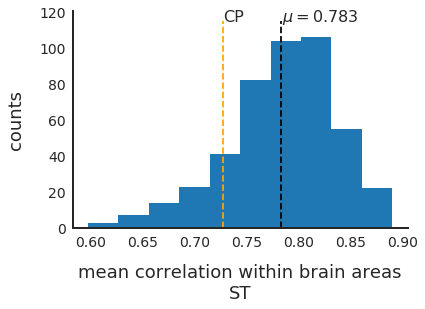

In [133]:
plt.hist(STcorr['mean'])
plt.xlabel("mean correlation within brain areas\nST")
plt.ylabel("counts")
#caudoputamen
plt.vlines(x=CPSTmeancorr, ymin=0, ymax=115, linestyles='--', colors='orange')
plt.text(CPSTmeancorr+0.0001, 115, "CP", fontsize=16)
#mean
plt.vlines(x=STcorr['mean'].mean(), ymin=0, ymax=115, linestyles='--')
plt.text(STcorr['mean'].mean()+0.001, 115, "$\mu = %.3f$" %STcorr['mean'].mean(), fontsize=16)

plt.savefig("051220_14.pdf", bbox_inches='tight')
plt.show()

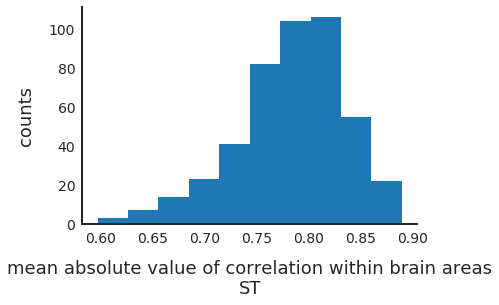

In [134]:
plt.hist(STcorr['absmean'])
plt.xlabel("mean absolute value of correlation within brain areas\nST")
plt.ylabel("counts")
#plt.savefig("050420_10.pdf", bbox_inches='tight')
plt.show()

/home/slu/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/slu/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


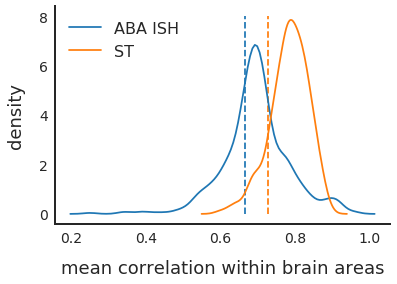

In [135]:
#combine ST and ABA means w/o absolute value
sns.kdeplot(ABAcorr['mean'],label='ABA ISH')
sns.kdeplot(STcorr['mean'], label='ST')
plt.xlabel("mean correlation within brain areas")
plt.ylabel("density")

#caudoputamen
plt.vlines(x=CPABAmeancorr, ymin=0, ymax=8, linestyles='--',colors='C0')
#plt.text(CPABAmeancorr+0.0001, 8, "CP", fontsize=16)
plt.vlines(x=CPSTmeancorr, ymin=0, ymax=8, linestyles='--',colors='C1')
#plt.text(CPSTmeancorr+0.0001, 8, "CP", fontsize=16)

plt.savefig("051220_15.pdf",bbox_inches='tight')
plt.show()

This doesn't really make sense that the sample correlation is higher in ST, but the performance is higher in ABA. However it is at least a bit convincing that the CP has a lower sample correlation than the mean in both datasets and is the worst performing area in ABA. Although I expected it to be on the much lower in ABA ISH at least.\
\
Follow-up Q's:
 - is it actually appropriate to average correlation coefficients? do i have to do fisher's z transform first (arctanh)?
 - spearman's rho?

__Gene variance within a brain region (distribution across all brain regions), average for all genes__

In [14]:
def getgenevar(data, propont):
    #initialize zeros dataframe to store entries
    allbyall_var = pd.Series(index=list(propont))
    
    #try z-scoring whole dataset
    #data = zscore(data)
    
    areas = list(propont)
    #for each column, brain area
    for i in range(propont.shape[1]):
        #print("col %d" %i)
        area1 = areas[i]

        #subset train and test sets for only samples in curr area
        Xcurr = data.loc[propont[area1] != 0, :]
        #try ranking in sample space
        #Xcurr = Xcurr.T.apply(lambda x: sp.stats.mstats.rankdata(x),axis=0)
        Xcurr = zscore(Xcurr.T) #try z-scoring on samples
            
        #calculate within brain area gene variance and average for all genes
        meangenevar = np.var(Xcurr, axis=1).mean()
            
        allbyall_var.iloc[i] = meangenevar
         
    return allbyall_var

In [15]:
ABAgenevar = getgenevar(leafABAvox, leafABApropont)

In [16]:
STgenevar = getgenevar(leafSTspots, leafSTpropont)

In [20]:
print(np.mean(ABAgenevar))
print(np.mean(STgenevar))

0.31381490674137413
0.22612127041550717


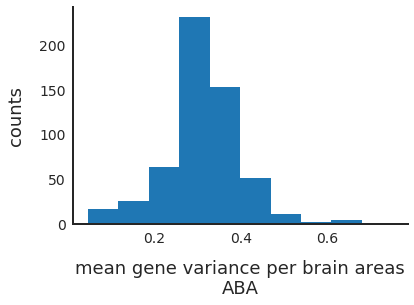

In [17]:
plt.hist(ABAgenevar)
plt.xlabel("mean gene variance per brain areas\nABA")
plt.ylabel("counts")
#plt.savefig("050420_13.pdf", bbox_inches='tight')
plt.show()

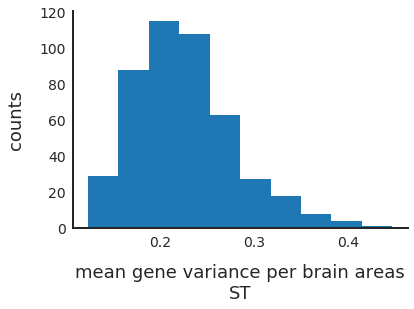

In [18]:
plt.hist(STgenevar)
plt.xlabel("mean gene variance per brain areas\nST")
plt.ylabel("counts")
#plt.savefig("050420_14.pdf", bbox_inches='tight')
plt.show()

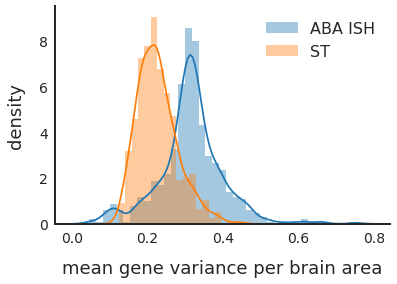

In [19]:
sns.distplot(ABAgenevar,label="ABA ISH")
sns.distplot(STgenevar,label="ST")
plt.xlabel("mean gene variance per brain area")
plt.ylabel("density")
#plt.ylim([-0.1,0.05])
plt.legend()
#plt.savefig("051220_17.pdf", bbox_inches='tight')
plt.show()

ABA ISH had higher gene variance within a brain region than the ST. Again... this is the opposite of what I expected. Since the ABA ISH performs higher than the ST and the ABA ISH has a lower dimensionality, I expected the gene variance within each brain area to be lower in ABA than in ST. 

__gene variance for whole dataset__

In [35]:
#try z-scoring in sample space first (genes don't work to calculate variance duh)
zleafABAvox = zscore(leafABAvox.T)
zleafSTspots = zscore(leafSTspots.T)

In [36]:
ABAvar = np.var(zleafABAvox, axis=0)
STvar = np.var(zleafSTspots, axis=0)

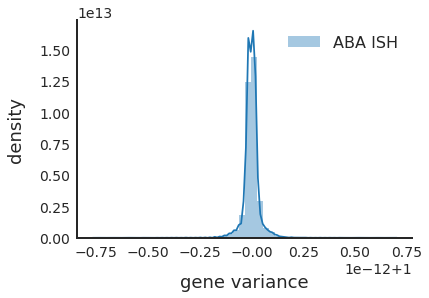

In [51]:
sns.distplot(ABAvar,label="ABA ISH")
#sns.distplot(STvar,label="ST")
plt.xlabel("gene variance")
plt.ylabel("density")
#plt.ylim([-0.0002, 0.012])
plt.legend()
plt.savefig("080520_9.pdf", bbox_inches='tight')
plt.show()

__pairwise gene-gene correlations for whole dataset__

Pearson's r

In [21]:
ABAcorrmatrix = np.corrcoef(leafABAvox, rowvar=False) #cols are genes

In [22]:
STcorrmatrix = np.corrcoef(leafSTspots, rowvar=False)

In [ ]:
ABAcorrmatrix_upper = ABAcorrmatrix[np.triu_indices_from(ABAcorrmatrix, k=1)]
#STcorrmatrix_upper = STcorrmatrix[np.triu_indices_from(STcorrmatrix, k=1)]

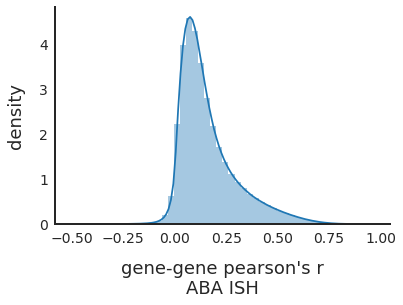

In [202]:
sns.distplot(ABAcorrmatrix_upper)
plt.xlabel("gene-gene pearson's r\nABA ISH")
plt.ylabel("density")
#plt.savefig("050820_1.pdf", bbox_inches='tight')
plt.show()

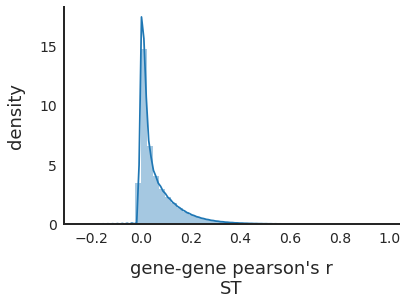

In [70]:
STcorrmatrix_upper = STcorrmatrix_upper[np.isnan(STcorrmatrix_upper) == False]
sns.distplot(STcorrmatrix_upper)
plt.xlabel("gene-gene pearson's r\nST")
plt.ylabel("density")
#plt.savefig("051220_1.pdf", bbox_inches='tight')
plt.show()

In [ ]:
sns.distplot(ABAcorrmatrix_upper,label="ABA ISH")
sns.distplot(STcorrmatrix_upper,label="ST")
plt.xlabel("gene-gene correlation\nPearson's r")
plt.ylabel("density")
#plt.ylim([-0.1,0.05])
plt.legend()
plt.savefig("051220_4.pdf", bbox_inches='tight')
plt.show()

Spearman's rho

In [23]:
rankedleafABAvox = leafABAvox.apply(lambda col: sp.stats.mstats.rankdata(col), axis=0)
ABAspearman = np.corrcoef(rankedleafABAvox, rowvar=False) #cols are genes

In [24]:
ABAspearman_upper = ABAspearman[np.triu_indices_from(ABAspearman, k=1)]

In [25]:
np.mean(ABAspearman_upper)

0.5249555366038159

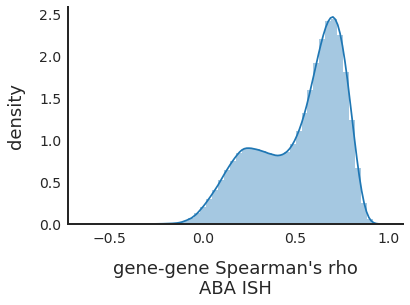

In [26]:
sns.distplot(ABAspearman_upper)
plt.xlabel("gene-gene Spearman's rho\nABA ISH")
plt.ylabel("density")
#plt.savefig("050820_2.pdf", bbox_inches='tight')
plt.show()

In [27]:
rankedleafSTspots = leafSTspots.apply(lambda col: sp.stats.mstats.rankdata(col), axis=0)
STspearman = np.corrcoef(rankedleafSTspots, rowvar=False)

In [28]:
STspearman_upper = STspearman[np.triu_indices_from(STspearman, k=1)]

In [29]:
np.mean(STspearman_upper)

0.04919581105860777

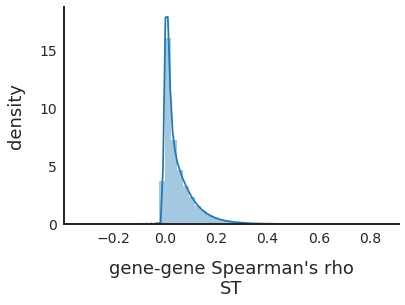

In [71]:
sns.distplot(STspearman_upper)
plt.xlabel("gene-gene Spearman's rho\nST")
plt.ylabel("density")
plt.savefig("051220_2.pdf", bbox_inches='tight')
plt.show()

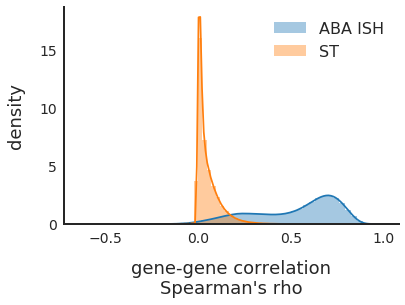

In [30]:
sns.distplot(ABAspearman_upper,label="ABA ISH")
sns.distplot(STspearman_upper,label="ST")
plt.xlabel("gene-gene correlation\nSpearman's rho")
plt.ylabel("density")
#plt.ylim([-0.1,0.05])
plt.legend()
#plt.savefig("051220_3.pdf", bbox_inches='tight')
plt.show()

__Average difference between a pair of brain regions: is there more DE using ABA data? but is that just because variance is lower rather than higher fold changes? (or effect sizes). Volcano plot like implicaiton of overfitting__

NOTE: this is hard to do, becuase the DE takes a long time to look at (limiting factor of CFS), but since I have to re-run that, I'll try to record this info when I get there as well.